# Boston Marathon

This is a clustering exercise using Boston Marathon race data from 2006.  The race data is clustered by times, finishing place, and gender.  In addition, geopy is used to find the latitude and longitude of the cities the runners come from and clustering is done based on distance from Boston.

https://github.com/llimllib/bostonmarathon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from geopy import distance
from geopy import geocoders
from geopy.geocoders import GoogleV3

## Read in csv and clean data

In [2]:
df = pd.read_csv('Boston_Marathon_Results2006.csv')

df['division'] = [x.split('/') for x in df['division']]
df['division_place'] = [int(x[0]) for x in df['division']]
df['division_num'] = [int(x[1]) for x in df['division']]
df['div_perc'] = 1 - df['division_place'] / df['division_num']

df['genderdiv'] = [x.split('/') for x in df['genderdiv']]
df['genderdiv_place'] = [int(x[0]) for x in df['genderdiv']]
df['genderdiv_num'] = [int(x[1]) for x in df['genderdiv']]
df['gender_perc'] = 1 - df['genderdiv_place'] / df['genderdiv_num']

df['overall'] = [x.split('/') for x in df['overall']]
df['overall_place'] = [int(x[0]) for x in df['overall']]
df['overall_num'] = [int(x[1]) for x in df['overall']]
df['overall_perc'] = 1 - df['overall_place'] / df['overall_num']

# Change gender to numerical variable
df['gender'] = np.where(df['gender'] == 'M', 1, 0)


In [3]:
df['location'] = df['city'] + ', ' + df['state'] + ' ' + df['country']

# Some locations do not have a state, this will replace it with city 
# and country 
df['location'] = df['location'].replace(np.NAN, 
                                        df['city'] + ' ' + df['country'])


In [4]:
# Create a locations data frame, not used until later with the 
# geopy code
locations = pd.DataFrame(df['location'].unique(), columns=['name'])

locations['lat'] = np.nan
locations['long'] = np.nan
locations.head()

,name,lat,long
0,Paarl RSA,NaN,NaN
1,Ehime JPN,NaN,NaN
2,Nairobi KEN,NaN,NaN
3,"Cobble Hill, BC CAN",NaN,NaN
4,Jurmala LAT,NaN,NaN


In [5]:
df.head()

,division,name,city,gender,age,official,bib,overall,state,genderdiv,...,division_place,division_num,div_perc,genderdiv_place,genderdiv_num,gender_perc,overall_place,overall_num,overall_perc,location
0,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,1,20,0.950000,1,23,0.956522,1,27,0.962963,Paarl RSA
1,"[3 , 4372]","Tosa, Reiko",Ehime,0,29,144.18,F1,"[26 , 19682]",NaN,"[3 , 7621]",...,3,4372,0.999314,3,7621,0.999606,26,19682,0.998679,Ehime JPN
2,"[9 , 4401]","Onsare, Wilson",Nairobi,1,29,133.78,2,"[9 , 19682]",NaN,"[9 , 12061]",...,9,4401,0.997955,9,12061,0.999254,9,19682,0.999543,Nairobi KEN
3,"[4 , 20]","Bergman, Alan J.",Cobble Hill,1,32,89.93,W2,"[4 , 27]",BC,"[4 , 23]",...,4,20,0.800000,4,23,0.826087,4,27,0.851852,"Cobble Hill, BC CAN"
4,"[2 , 4372]","Prokopcuka, Jelena",Jurmala,0,29,143.80,F2,"[25 , 19682]",NaN,"[2 , 7621]",...,2,4372,0.999543,2,7621,0.999738,25,19682,0.998730,Jurmala LAT


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19715 entries, 0 to 19714
Data columns (total 22 columns):
division           19715 non-null object
name               19715 non-null object
city               19715 non-null object
gender             19715 non-null int64
age                19715 non-null int64
official           19715 non-null float64
bib                19715 non-null object
overall            19715 non-null object
state              18640 non-null object
genderdiv          19715 non-null object
net                0 non-null float64
country            19715 non-null object
division_place     19715 non-null int64
division_num       19715 non-null int64
div_perc           19715 non-null float64
genderdiv_place    19715 non-null int64
genderdiv_num      19715 non-null int64
gender_perc        19715 non-null float64
overall_place      19715 non-null int64
overall_num        19715 non-null int64
overall_perc       19715 non-null float64
location           19715 non-null obj

In [7]:
# Just for fun, my results
df[df['name'] == 'Schuil, Crystal J.']

,division,name,city,gender,age,official,bib,overall,state,genderdiv,...,division_place,division_num,div_perc,genderdiv_place,genderdiv_num,gender_perc,overall_place,overall_num,overall_perc,location
19267,"[3819 , 4372]","Schuil, Crystal J.",Cambridge,0,20,276.47,23071,"[17397 , 19682]",MA,"[6540 , 7621]",...,3819,4372,0.126487,6540,7621,0.141845,17397,19682,0.116096,"Cambridge, MA USA"


In [24]:
df[df['overall_place']==1]

,division,name,city,gender,age,official,bib,overall,state,genderdiv,...,division_place,division_num,div_perc,genderdiv_place,genderdiv_num,gender_perc,overall_place,overall_num,overall_perc,location
0,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,1,20,0.950000,1,23,0.956522,1,27,0.962963,Paarl RSA
15,"[1 , 4401]","Cheruiyot, Robert",Nandi District,1,27,127.23,8,"[1 , 19682]",NaN,"[1 , 12061]",...,1,4401,0.999773,1,12061,0.999917,1,19682,0.999949,Nandi District KEN
19709,"[1 , 4]","Dowling, Joseph M.",Old Greenwich,1,66,101.77,23609,"[1 , 6]",CT,"[1 , 4]",...,1,4,0.750000,1,4,0.750000,1,6,0.833333,"Old Greenwich, CT USA"


In [25]:
df['overall_num'].unique()

array([   27, 19682,     6])

Hmmm, I remember being faster :-)  At least I finished?

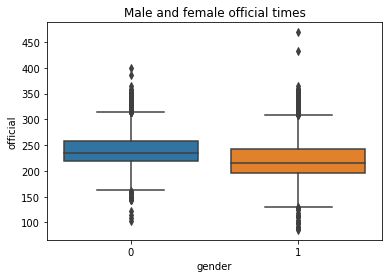

In [8]:
sns.boxplot(x='gender', y='official', data=df)
plt.title('Male and female official times')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


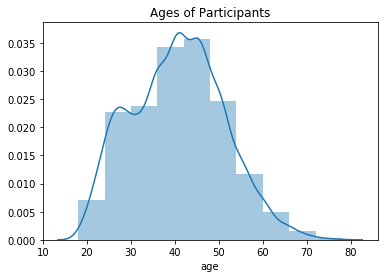

In [13]:
sns.distplot(df.loc[:,'age'], bins=10, hist=True)
plt.title('Ages of Participants')
plt.show()

## Kmean clustering

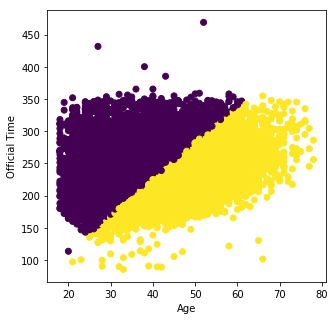

In [16]:
# Leave out categorical features for now
features = ['gender', 'age', 'official', 'overall_perc', 'div_perc']

X = df[features]

# Normalize the data
X_norm = normalize(X)

# Reduce it to two components (just for starting)
# This is just for graphing
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values
# Use 2 clusters, best silhouette score below
y_pred = KMeans(n_clusters=2).fit_predict(X_norm)

# Plot the solution (use pca just for plotting)
fig = plt.figure(figsize=(5, 5))
plt.scatter(X['age'], X['official'], c=y_pred)
plt.ylabel('Official Time')
plt.xlabel('Age')
plt.show()

These appear to be clustered based on how fast you are for your age.  

In [17]:
rs = ShuffleSplit(n_splits=2, test_size=0.5)
splits = list(rs.split(X_norm))
X1 = X_norm[splits[0][0]]
X2 = X_norm[splits[0][1]]
X3 = X_norm[splits[1][0]]
X4 = X_norm[splits[1][1]]

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.5724387037987353
0.563603194757746
0.5650567002750224
0.5708206329652036


In [18]:
clusters = range(2, 10)
all_means = []
for cluster in clusters:
    means = []
    for sample in [X1, X2, X3, X4]:
        ypred = KMeans(n_clusters=cluster).fit_predict(sample)
        means.append(metrics.silhouette_score(sample, ypred, metric='euclidean'))
    all_means.append((np.mean(means), np.std(means), cluster))

all_means.sort(reverse=True)
print(all_means[:3])

[(0.5679798079491768, 0.0037299913026373056, 2), (0.5311434252150156, 0.002393436287256124, 3), (0.5113991736056503, 0.002176661212655392, 4)]


The best silhouette score averaged over 4 samples is for 2 clusters.

# Mean-shift

Number of estimated clusters: 5


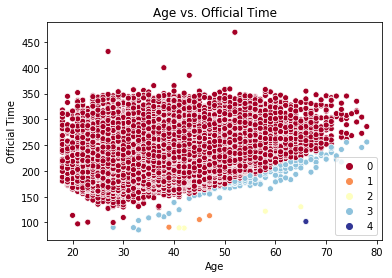

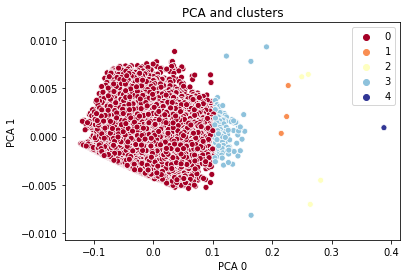

In [19]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
#fig = plt.figure(figsize=(5, 5))
sns.scatterplot(X['age'], X['official'], hue=labels, legend='full', palette='RdYlBu')
plt.ylabel('Official Time')
plt.xlabel('Age')
plt.title('Age vs. Official Time')
plt.show()

sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=labels, legend='full', palette='RdYlBu')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.title('PCA and clusters')
plt.show()


This predicted 5 clusters.  The majority of the people are in one of the clusters. 

In [21]:
# Use same splits as for Kmeans
for sample in [X1, X2, X3, X4]:
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(sample)
    labels = ms.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.48797853911846195
0.5403902883428482
0.5885981669939526
0.48638366749837475


# Add in some latitude and longitude
This was run and used to create csv file locations_csv.  The locations dataframe was created closer to the top of this file.  Running this only one time because Google charges for querying.

In [ ]:
# Do not save to github with api_key
# This is what was used to write the locations_csv.csv file
# Running this cost $36, so won't run again
geolocator = GoogleV3(api_key='Insert API Key Here')

#create an input address string
#you can also build this by reading from an input database and building a string
locations['latlong'] = np.nan

def find_lat_long(place):
    
    inputAddress = place
    
    #do the geocode
    location = geolocator.geocode(inputAddress, timeout=10)

    if location is None:
        return np.nan
    else:
        # Do not technically need to write to a csv, but this took a long time to run, and this 
        # saves the progress and makes it easier to load back in without running again
        with open('locations_file.csv','a') as fd:
            # write to csv as it is run in case it crashes, don't have to look it up again
            fd.write(place + ' ' + ' / ' + str(location.latitude) + ' / ' + str(location.longitude) + '\n')
        return str(location.latitude) + ', ' + str(location.longitude)
    

In [ ]:
# find the latitude and longitude for every location
locations['latlong']= locations.apply(lambda x: find_lat_long(x['name']), axis=1)

In [ ]:
locations[locations['latlong'].isna()==True]

In [27]:
# Resaved locations file as locations_csv, loaded back in
lat_long = pd.read_csv('locations_csv.csv', names=['place_name', 'lat', 'long'], header=0)
lat_long['place_name'] = lat_long['place_name'].str.strip()

In [28]:
lat_long.head()

,place_name,lat,long
0,Paarl RSA,-33.734230,18.962109
1,Ehime JPN,33.841624,132.765681
2,Nairobi KEN,-1.292066,36.821946
3,"Cobble Hill, BC CAN",48.688350,-123.603089
4,Jurmala LAT,56.947079,23.616848


In [29]:
boston_lat = 42.361145
boston_long = -71.057083

# Used to measure how far cities are from Boston
def boston_distance(lat, long):
    # default Geopy uses geodesic distance
    try:
        dist = distance.distance((boston_lat, boston_long), (lat, long)).miles
        return dist
    except:
        return np.nan

In [30]:
lat_long['distance']= lat_long.apply(lambda x: boston_distance(x['lat'], x['long']), axis=1)

In [31]:
# Only run 1 time!
df = df.merge(lat_long, left_on='location', right_on='place_name', how='left')
df.head()

,division,name,city,gender,age,official,bib,overall,state,genderdiv,...,genderdiv_num,gender_perc,overall_place,overall_num,overall_perc,location,place_name,lat,long,distance
0,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,23,0.956522,1,27,0.962963,Paarl RSA,Paarl RSA,-33.734230,18.962109,7729.026455
1,"[1 , 20]","Van Dyk, Ernst",Paarl,1,33,85.48,W1,"[1 , 27]",NaN,"[1 , 23]",...,23,0.956522,1,27,0.962963,Paarl RSA,Paarl RSA,-33.734230,18.962109,7729.026455
2,"[3 , 4372]","Tosa, Reiko",Ehime,0,29,144.18,F1,"[26 , 19682]",NaN,"[3 , 7621]",...,7621,0.999606,26,19682,0.998679,Ehime JPN,Ehime JPN,33.841624,132.765681,6974.799964
3,"[3 , 4372]","Tosa, Reiko",Ehime,0,29,144.18,F1,"[26 , 19682]",NaN,"[3 , 7621]",...,7621,0.999606,26,19682,0.998679,Ehime JPN,Ehime JPN,33.841624,132.765681,6974.799964
4,"[9 , 4401]","Onsare, Wilson",Nairobi,1,29,133.78,2,"[9 , 19682]",NaN,"[9 , 12061]",...,12061,0.999254,9,19682,0.999543,Nairobi KEN,Nairobi KEN,-1.292066,36.821946,7189.949035


In [32]:
# 57 records without distance, could try maps, but going to drop
df = df.dropna(subset=['lat', 'long', 'distance'], axis=0)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19784 entries, 0 to 19840
Data columns (total 26 columns):
division           19784 non-null object
name               19784 non-null object
city               19784 non-null object
gender             19784 non-null int64
age                19784 non-null int64
official           19784 non-null float64
bib                19784 non-null object
overall            19784 non-null object
state              18712 non-null object
genderdiv          19784 non-null object
net                0 non-null float64
country            19784 non-null object
division_place     19784 non-null int64
division_num       19784 non-null int64
div_perc           19784 non-null float64
genderdiv_place    19784 non-null int64
genderdiv_num      19784 non-null int64
gender_perc        19784 non-null float64
overall_place      19784 non-null int64
overall_num        19784 non-null int64
overall_perc       19784 non-null float64
location           19784 non-null obj

# And back to clustering

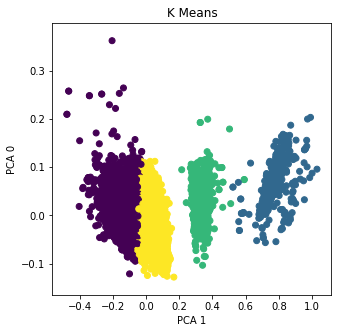

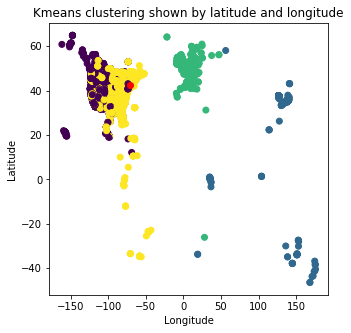

0.4191242378981669


In [34]:
# Leave out categorical features for now
features2 = ['gender', 'age', 'official', 'overall_perc', 'div_perc', 'lat', 'long']

X = df[features2]

# Normalize the data
X_norm = normalize(X)

# Reduce it to two components (just for starting)
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values
y_pred = KMeans(n_clusters=4).fit_predict(X_norm)

# Plot the solution (use pca just for plotting)
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:,0], X_pca[:, 1], c=y_pred)
plt.title('K Means')
plt.ylabel('PCA 0')
plt.xlabel('PCA 1')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.scatter(X['long'], X['lat'], c=y_pred)
plt.scatter(boston_long, boston_lat, c='r', label='Boston')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Kmeans clustering shown by latitude and longitude')
plt.show()

print(metrics.silhouette_score(X_norm, y_pred, metric='euclidean'))

In [35]:
rs = ShuffleSplit(n_splits=2, test_size=0.5)
splits = list(rs.split(X_norm))
X1 = X_norm[splits[0][0]]
X2 = X_norm[splits[0][1]]
X3 = X_norm[splits[1][0]]
X4 = X_norm[splits[1][1]]

for sample in [X1, X2, X3, X4]:
    ypred = KMeans(n_clusters=4).fit_predict(sample)
    print(metrics.silhouette_score(sample, ypred, metric='euclidean'))


0.4146875376292145
0.4241563413715435
0.4281780401436075
0.41390567748287205


Number of estimated clusters: 10


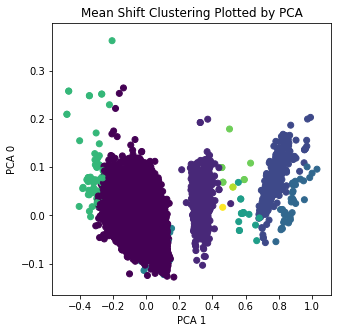

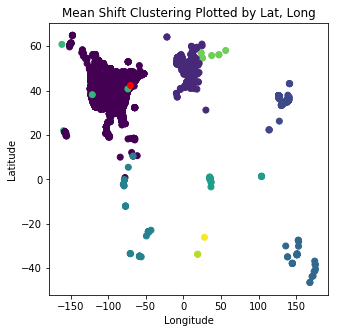

0.5285653485885528


In [36]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_norm, quantile=0.4, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
# Plot the solution (use pca just for plotting)
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:,0], X_pca[:, 1], c=labels)
plt.title('Mean Shift Clustering Plotted by PCA')
plt.ylabel('PCA 0')
plt.xlabel('PCA 1')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.title('Mean Shift Clustering Plotted by Lat, Long')
plt.scatter(X['long'], X['lat'], c=labels)
plt.scatter(boston_long, boston_lat, c='r', label='Boston')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

print(metrics.silhouette_score(X_norm, labels, metric='euclidean'))

In [37]:
for sample in [X1, X2, X3, X4]:
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(sample)
    labels = ms.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.4176772765418554
0.4139343222622009
0.49546628607535415
0.3842682810007295


# Geographic Grouping

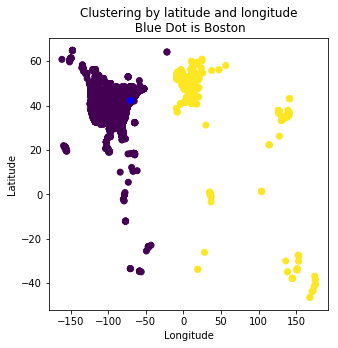

In [38]:
features_geo = ['lat', 'long']
X = df[features_geo]

# Normalize the data
X_norm = normalize(X)

# Reduce it to two components (just for starting)

# Calculate predicted values
y_pred = KMeans(n_clusters=2).fit_predict(X_norm)

# Plot the solution (use pca just for plotting)
fig = plt.figure(figsize=(5, 5))
plt.scatter(X['long'], X['lat'], c=y_pred)
plt.scatter(boston_long, boston_lat, c='b')
plt.title('Clustering by latitude and longitude\n Blue Dot is Boston')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [39]:
# Silhouette score better for 3 than 5 or 10 clusters
for sample in [X1, X2, X3, X4]:
    ypred = KMeans(n_clusters=2).fit_predict(sample)
    print(metrics.silhouette_score(sample, ypred, metric='euclidean'))

0.7591343743953308
0.7680934701001254
0.761694229210335
0.7657711743981629


In [40]:
clusters = range(2, 10)
all_means = []
for cluster in clusters:
    means = []
    for sample in [X1, X2, X3, X4]:
        ypred = KMeans(n_clusters=cluster).fit_predict(sample)
        means.append(metrics.silhouette_score(sample, ypred, metric='euclidean'))
    all_means.append((np.mean(means), np.std(means), cluster))

In [41]:
all_means.sort(reverse=True)

In [42]:
all_means

[(0.7636733120259885, 0.0034805727811366783, 2),
 (0.42014477123577165, 0.006217472652242667, 4),
 (0.3977039818587955, 0.010758789453859458, 3),
 (0.3600193785583019, 0.005105267282549755, 5),
 (0.31953081600121813, 0.002967154750110588, 7),
 (0.31942657316635015, 0.0015857797848811586, 6),
 (0.3013067153125779, 0.0032773392169292643, 8),
 (0.2883146121501566, 0.002543913638781439, 9)]

When clustering by geographic area, the clustering with the best silhouette score for kmeans clustering is two clusters.  When plotted versus lattitude and longitude, it appears that this division is being made along th longitude line of -10.  One possible reason for this is that the clustering doesn't take into account the fa